In [2]:

import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [3]:
df = pd.read_csv('../data/Subreddits_Data.csv', usecols = ['subreddit','selftext', 'title', 'corrected_title', 'char_count', 'word_count', 'neg', 'neu', 'pos', 'compound'])
df[['selftext', 'title', 'corrected_title']] = df[['selftext', 'title', 'corrected_title']].fillna('')
cat_col = ['corrected_title']
num_col = ['word_count', 'char_count', 'compound', 'pos', 'neu', 'neg']

In [4]:
df.head()

,subreddit,selftext,title,corrected_title,char_count,word_count,neg,neu,pos,compound
0,1,I’ve foreign friends who keep misusing each wo...,what’s the difference between an illness and ...,what’s the difference between an illness and ...,55,9,0.278,0.722,0.0,-0.4019
1,1,Given all of time why has no one conquered tim...,"if space and time are infinite, why has no on...","if space and time are infinite, why has no on...",59,13,0.278,0.722,0.0,-0.4019
2,1,[removed],could time travel be possible?,could time travel be possible?,30,5,0.278,0.722,0.0,-0.4019
3,1,,why do humans need such a wide range of nutri...,why do humans need such a wide range of nutri...,137,22,0.278,0.722,0.0,-0.4019
4,1,[removed],how does the moon’s orbit and rotation work?,how does the moon’s orbit and rotation work?,44,8,0.278,0.722,0.0,-0.4019


In [5]:
spell = SpellChecker()
df['corrected_title'] = df['corrected_title'].apply(lambda x: ' '.join(spell.split_words(x)))

In [6]:
# count Vectorize title data and remove stop words
stop_words  = stopwords.words('english')
count_vec_pipe = Pipeline(
                            [
                                ('vect', CountVectorizer(stop_words=stop_words, ngram_range=(1,1))),
                            ]
                        )
count_vec_pipe.fit(df['corrected_title'])
df_count_vec = pd.DataFrame(count_vec_pipe.transform(df['corrected_title']).A, columns=count_vec_pipe.get_feature_names_out())
master_df = pd.concat([df, df_count_vec], axis=1)
master_df = master_df.loc[:,~master_df.columns.duplicated()]


In [7]:
zero = master_df[master_df['subreddit']==0]
zero = zero.drop(columns=['word_count', 'char_count', 'neu', 'neg', 'pos', 'compound'])

In [8]:
one = master_df[master_df['subreddit']==1]
one = one.drop(columns=['word_count', 'char_count', 'neu', 'neg', 'pos', 'compound'])

In [9]:
# Graph common words
common_words_one = one.sum(numeric_only=True, axis=0).sort_values().tail(25)
common_words_zero = zero.sum(numeric_only=True, axis=0).sort_values().tail(25)

In [10]:
additional_stop_words = set(list(common_words_one.index)).intersection(set(list(common_words_zero.index)))

In [11]:
stop_words  = stopwords.words('english')
count_vec_pipe = Pipeline(
                            [
                                ('vect', CountVectorizer(stop_words=stop_words + list(additional_stop_words), ngram_range=(1,1))),
                            ]
                        )
count_vec_pipe.fit(df['corrected_title'])
df_count_vec = pd.DataFrame(count_vec_pipe.transform(df['corrected_title']).A, columns=count_vec_pipe.get_feature_names_out())
master_df = pd.concat([df, df_count_vec], axis=1)
master_df = master_df.loc[:,~master_df.columns.duplicated()]

In [12]:
X = master_df.drop(columns=['subreddit', 'selftext', 'title', 'corrected_title'])
y = master_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

vc1 = VotingClassifier(
    [
        ('adb', AdaBoostClassifier()),
        ('boosting', xgb.XGBClassifier()),
        ('bagging', BaggingClassifier()),
        ('rfc', RandomForestClassifier()),
        ('etc', ExtraTreesClassifier()),
    ],
    weights = [.1, .1, .1, .30, .30],
    n_jobs=2
)
ct1 = ColumnTransformer([
    ('ss', StandardScaler(), num_col), # polynomial numeric columns
], remainder = 'passthrough')
pipe = Pipeline([
    ('ct', ct1),
    ('vc1', vc1)
])
pipe.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(1.0, 0.8694633231778768)

<Figure size 1080x720 with 0 Axes>

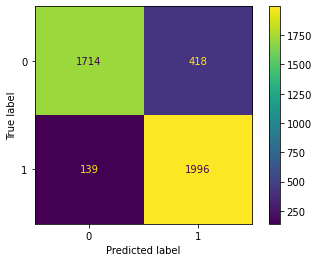

In [ ]:
plt.figure(figsize=(15,10))
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

In [13]:
# master_df.dtypes
X = master_df.drop(columns=['subreddit', 'selftext', 'title', 'corrected_title'])
y = master_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
clf1 = LogisticRegression(random_state=10, max_iter=10000)
clf2 = RandomForestClassifier(random_state=10)
clf3 = GaussianNB()
ct = ColumnTransformer([
    ('ss', StandardScaler(), num_col),
], remainder = 'passthrough')

# eclf1 = VotingClassifier(estimators=[
#                                     ('lr', clf1), 
#                                     ('rf', clf2), 
#                                     ('gnb', clf3)], voting='hard', n_jobs=-1)
# eclf1 = eclf1.fit(X_train, y_train)


pipe = Pipeline([
    ('cv', ct),
    ('vc', VotingClassifier(
                    estimators=[
                                ('bc', BaggingClassifier(random_state=10)),
                                ('lr', clf1), 
                                ('rf', clf2), 
                                ('gnb', clf3)
                               ], 
                    voting='soft', n_jobs=2)),
])
# pipe.fit(X_train, y_train)
pipe_params = {
    'vc__bc__max_features':[1, 3, 5],
    'vc__lr__penalty':['l2', 'elasticnet'],
    'vc__lr__solver':['newton-cg', 'sag', 'lbfgs'],
    'vc__rf__n_estimators':[50, 100, 150],
}
gs = GridSearchCV(
    pipe,
    pipe_params,
    n_jobs=2
)
gs.fit(X_train, y_train)


/Users/robertsarno/Documents/Spring_2022/Learning/General_Assembly/GA_lib/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/robertsarno/Documents/Spring_2022/Learning/General_Assembly/GA_lib/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/robertsarno/Documents/Spring_2022/Learning/General_Assembly/GA_lib/lib/python3.9/site-packages

GridSearchCV(estimator=Pipeline(steps=[('cv',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['word_count',
                                                                          'char_count',
                                                                          'compound',
                                                                          'pos',
                                                                          'neu',
                                                                          'neg'])])),
                                       ('vc',
                                        VotingClassifier(estimators=[('bc',
                                                                     

In [15]:
gs.score(X_train,y_train), gs.score(X_test, y_test), gs.best_score_

(0.9499140490701672, 0.7785329271150692, 0.7645722511234856)